# Model - CIC IoT 2023 Dataset for Cybersecurity Research

[University of New Brunswick - Canadian Institute for Cybersecurity](https://www.unb.ca/cic/datasets/index.html)

# Imports

In [1]:
import os
import sys
import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

from IPython.display import HTML

sys.path.append('../')
n_jobs = 40

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from lightgbm import LGBMClassifier

## Definitions

In [3]:
import utils
import model_utils
import visualization as viz

from multi_stage_classifier import MultiStageClassifier, ModelStage

constants = utils.get_constants()
seed = constants['seed']

train_parquet_path = constants['train_parquet_path']

features = constants['features']
protocol_layer = constants['protocol_layer']
protocol_layer_map = constants['protocol_layer_map']
attack_category = constants['attack_category']
attack_category_map = constants['attack_category_map']

## Read datasets

In [4]:
df = pd.read_parquet(train_parquet_path)

features_list = utils.get_features_list(df)
print(features_list)

['flow_duration', 'Header_Length', 'Duration', 'Rate', 'fin_flag_number', 'syn_flag_number', 'rst_flag_number', 'psh_flag_number', 'ack_flag_number', 'ack_count', 'syn_count', 'fin_count', 'urg_count', 'rst_count', 'HTTP', 'HTTPS', 'DNS', 'SSH', 'TCP', 'UDP', 'ICMP', 'IPv', 'Tot sum', 'Min', 'Max', 'AVG', 'Std', 'Tot size', 'IAT', 'Number', 'Radius', 'Covariance', 'Variance']


# Model (2 Stages)

In [5]:
simplified_first_layer_labels = {'DDoS', 'DoS', 'Mirai'}
simplified_second_layer_labels = {'Spoofing', 'Recon', 'Web', 'BruteForce'}

first_layer_labels = {
    attack_type
    for layer_attack in simplified_first_layer_labels
    for attack_type in attack_category[layer_attack]
}

second_layer_labels = {
    attack_type
    for layer_attack in simplified_second_layer_labels
    for attack_type in attack_category[layer_attack]
}

## First Stage - DDoS / DoS / Mirai

Here we focus on recall... **TODO: Explain why**

### 33+1 Attacks

In [6]:
%%time

first_stage_labels = (
    df.label
    .where(df.label.isin(first_layer_labels), 'BenignTraffic')
    .astype('category')
    .cat.remove_unused_categories()
)

first_stage_df_split = model_utils.get_train_test_split(
    df,
    target=first_stage_labels,
    # sample_size=10_000_000,
    train_frac=0.80
)

Training dataset size: 29.9M (80.0%).
Test dataset size: 7.5M (20.0%).
CPU times: user 33.3 s, sys: 5.17 s, total: 38.5 s
Wall time: 38.4 s


#### Search Hyperparameters

In [9]:
%%time

first_stage_model = DecisionTreeClassifier(
    criterion='entropy',
    class_weight='balanced',
    random_state=seed
)

param_grid = {
    'min_samples_split': range(2, 11),
}

grid_search = GridSearchCV(
    estimator=first_stage_model,
    param_grid=param_grid,
    cv=4,
    refit=False,
    n_jobs=n_jobs,
    verbose=1
)

grid_search.fit(df[features_list], first_stage_labels)

print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Cross-Validation Score: {grid_search.best_score_}")

Fitting 4 folds for each of 9 candidates, totalling 36 fits
Best Parameters: {'min_samples_split': 6}
Best Cross-Validation Score: 0.9910792886228353
CPU times: user 16min 8s, sys: 23.9 s, total: 16min 32s
Wall time: 32min 51s


#### 1st Stage Model

Execution time (Model fit): 0:12:45.738976
Execution time (Predict): 0:00:03.866566
                         precision    recall  f1-score   support

          BenignTraffic     0.9999    0.9999    0.9999    316650
 DDoS-ACK_Fragmentation     0.9995    0.9998    0.9997     45328
        DDoS-HTTP_Flood     0.9974    0.9989    0.9981      4589
        DDoS-ICMP_Flood     1.0000    1.0000    1.0000   1151804
DDoS-ICMP_Fragmentation     0.9997    0.9998    0.9998     72249
      DDoS-PSHACK_Flood     1.0000    1.0000    1.0000    654481
       DDoS-RSTFINFlood     1.0000    1.0000    1.0000    648317
         DDoS-SYN_Flood     0.9999    0.9999    0.9999    649075
         DDoS-SlowLoris     0.9950    0.9974    0.9962      3799
DDoS-SynonymousIP_Flood     0.9999    0.9999    0.9999    574550
         DDoS-TCP_Flood     1.0000    1.0000    1.0000    720389
         DDoS-UDP_Flood     0.9998    0.9998    0.9998    866635
 DDoS-UDP_Fragmentation     0.9995    0.9997    0.9996     46208
     

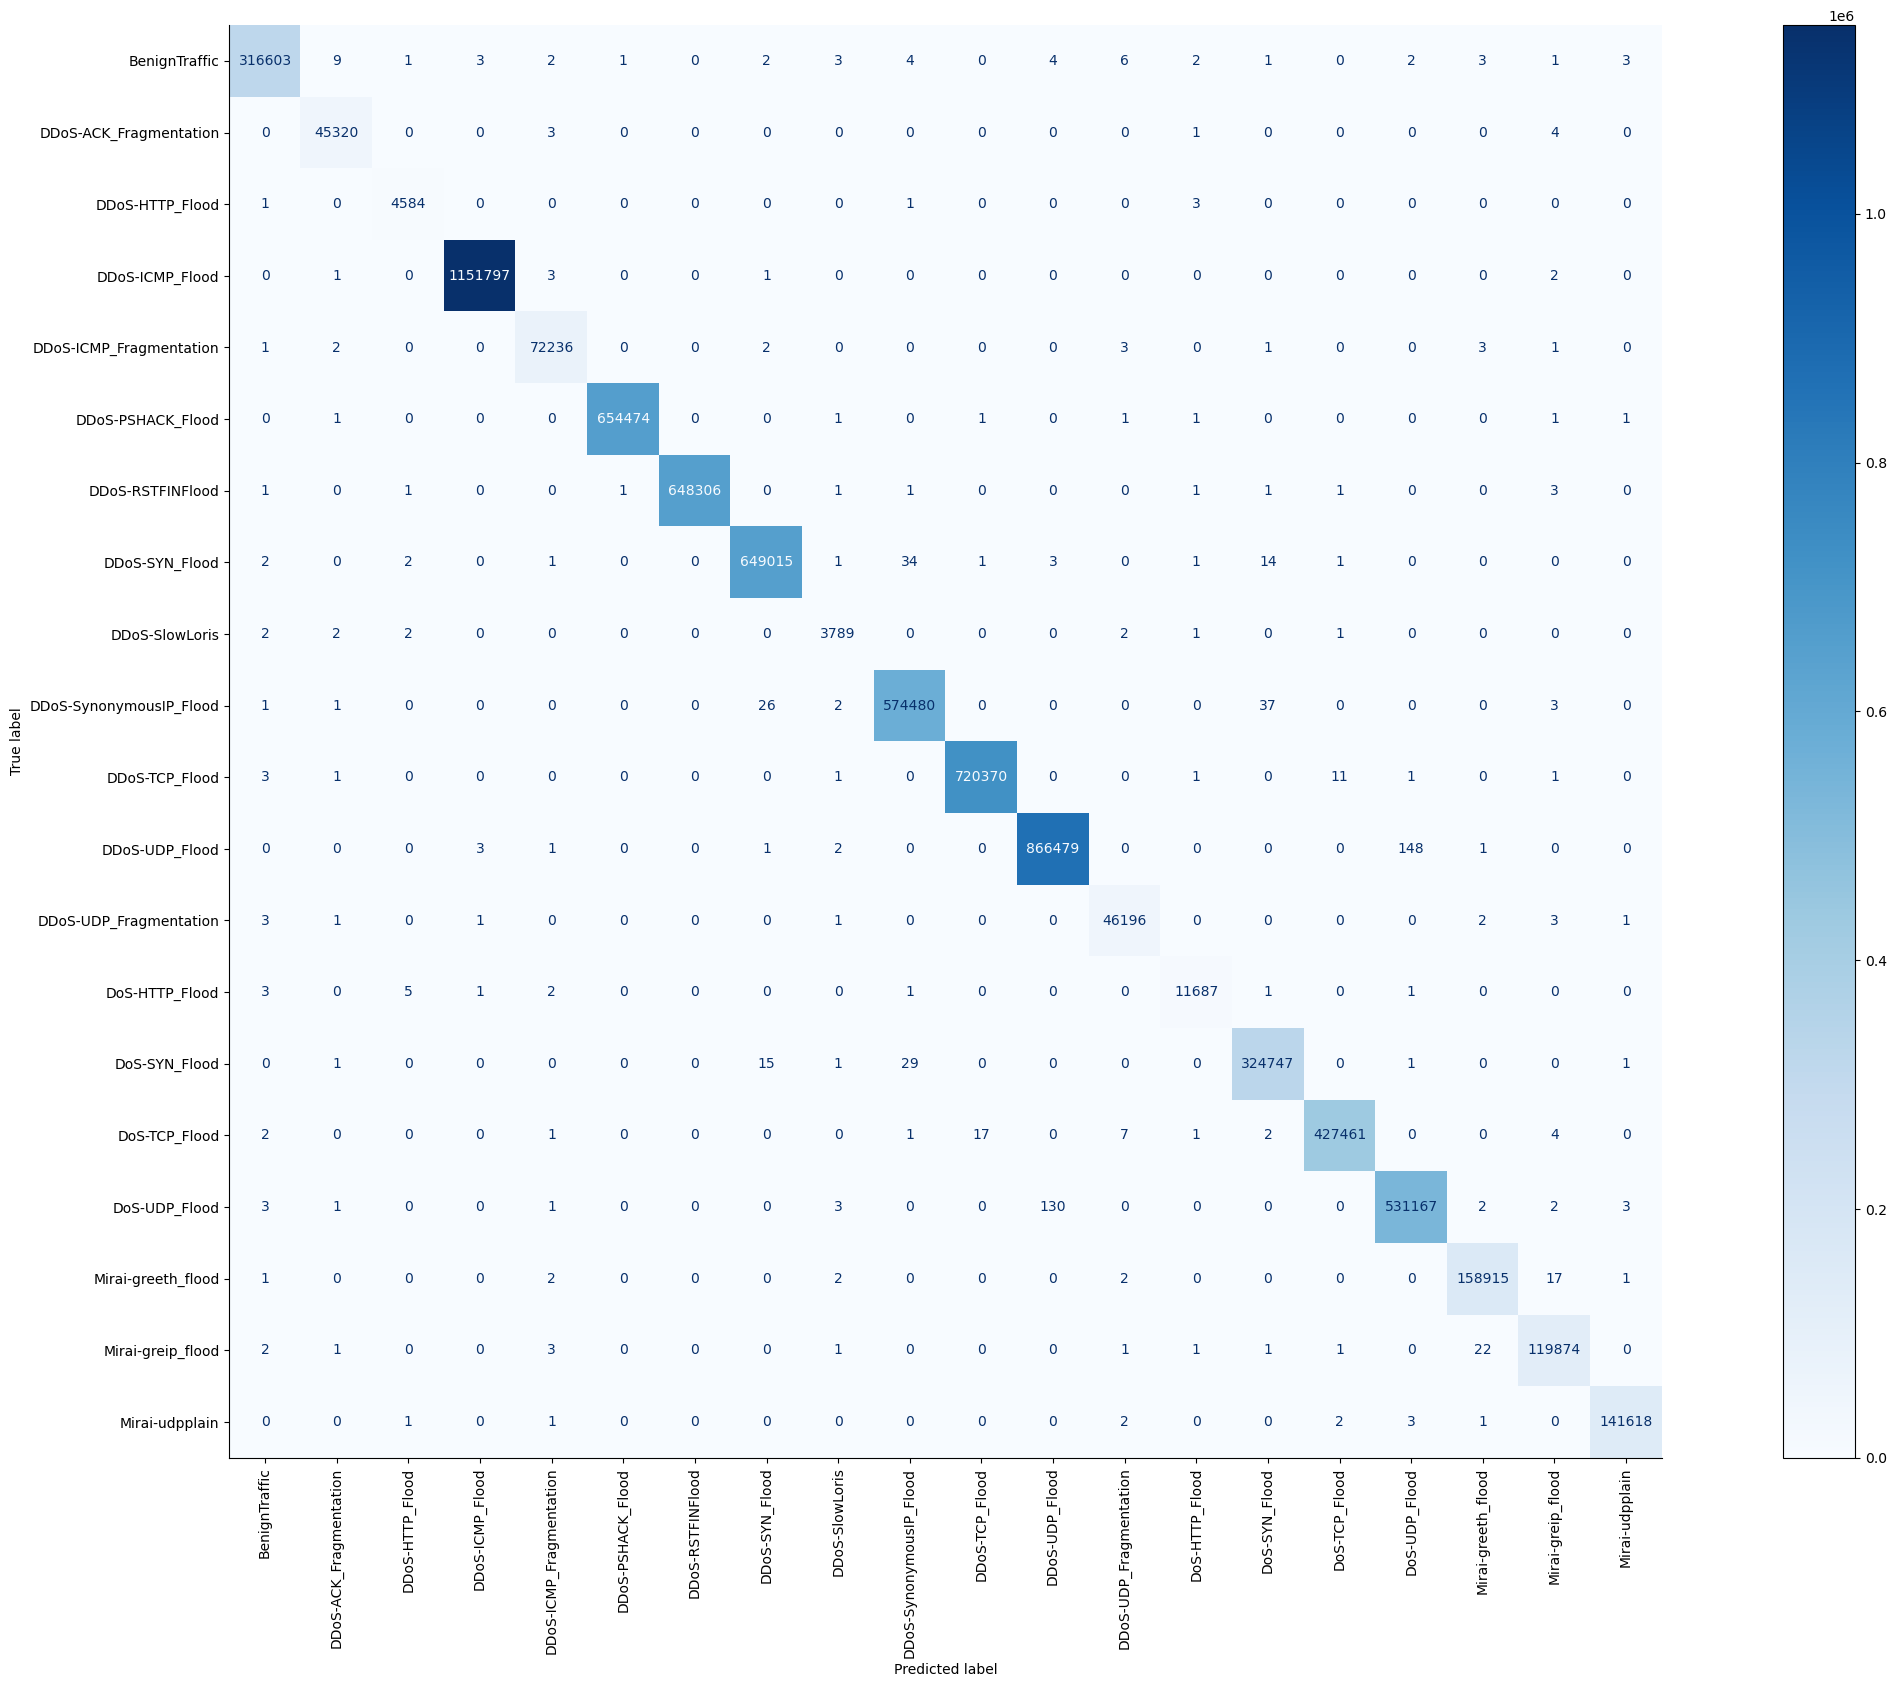

In [10]:
%%time

first_stage_model = DecisionTreeClassifier(
    criterion='entropy',
    class_weight='balanced',
    min_samples_split=6,
    random_state=seed
)

X_train, X_test, y_train, y_test = first_stage_df_split

model_utils.train_model(first_stage_model, X_train, y_train)
model_utils.evaluate_model(first_stage_model, X_test, y_test)

### 7+1 Attacks

In [7]:
%%time

simplified_first_stage_labels = (
    df.general_label
    .where(df.general_label.isin(simplified_first_layer_labels), 'Benign')
    .astype('category')
    .cat.remove_unused_categories()
)

simplified_first_stage_df_split = model_utils.get_train_test_split(
    df,
    target=simplified_first_stage_labels,
    # sample_size=20_000_000,
    train_frac=0.80
)

Training dataset size: 29.9M (80.0%).
Test dataset size: 7.5M (20.0%).
CPU times: user 33.1 s, sys: 3.81 s, total: 36.9 s
Wall time: 36.9 s


Execution time (Model fit): 0:10:08.682047
Execution time (Predict): 0:00:02.399353
              precision    recall  f1-score   support

      Benign     0.9999    0.9999    0.9999    316650
        DDoS     1.0000    0.9999    1.0000   5437424
         DoS     0.9998    0.9998    0.9998   1295304
       Mirai     0.9999    1.0000    0.9999    420475

    accuracy                         0.9999   7469853
   macro avg     0.9999    0.9999    0.9999   7469853
weighted avg     0.9999    0.9999    0.9999   7469853

CPU times: user 10min 55s, sys: 8.64 s, total: 11min 4s
Wall time: 11min 2s


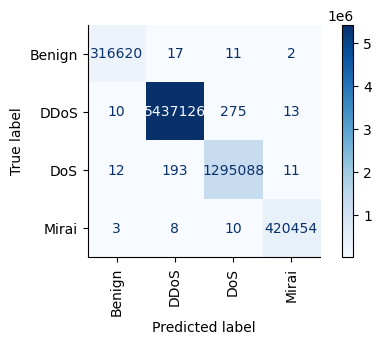

In [8]:
%%time

simplified_first_stage_model = DecisionTreeClassifier(
    criterion='entropy',
    class_weight='balanced',
    min_samples_split=6,
    random_state=seed
)

X_train, X_test, y_train, y_test = simplified_first_stage_df_split

model_utils.train_model(simplified_first_stage_model, X_train, y_train)
model_utils.evaluate_model(simplified_first_stage_model, X_test, y_test)

## Second Stage - Spoofing / Recon / Web / Brute Force

In [9]:
df_second_stage = df[~df.general_label.isin(simplified_first_layer_labels)]

### 33 + 1 Attacks

In [10]:
%%time

second_stage_target = (
    df_second_stage.label
    .where(df_second_stage.label.isin(second_layer_labels), 'BenignTraffic')
    .astype('category')
    .cat.remove_unused_categories()
)

second_stage_df_split = model_utils.get_train_test_split(
    df_second_stage,
    target=second_stage_target,
    train_frac=0.80
)

Training dataset size: 1.3M (80.0%).
Test dataset size: 316.3k (20.0%).
CPU times: user 1.16 s, sys: 180 ms, total: 1.34 s
Wall time: 1.34 s


#### Search Hyperparameters

In [20]:
# %%time

# second_stage_model = RandomForestClassifier(
#     criterion='entropy',
#     class_weight='balanced',
#     bootstrap=False,
#     n_jobs=10,
#     random_state=seed
# )

# param_grid = {
#     'min_samples_split': [2, 3, 5, 6],
#     'max_depth': [45, 50, 55, 60, None],
#     'max_features': [15], # [14, 15, 16, 17, 18, 19],
#     'n_estimators': [80], # [70, 80, 90, 100, 110],
# }

# grid_search = GridSearchCV(
#     estimator=second_stage_model,
#     param_grid=param_grid,
#     cv=3,
#     # refit=False,
#     n_jobs=10,
#     verbose=1
# )

# grid_search.fit(df[features_list], first_stage_labels)

# print(f"Best Parameters: {grid_search.best_params_}")
# print(f"Best Cross-Validation Score: {grid_search.best_score_}")

#### Model

Execution time (Model fit): 0:03:38.107737
Execution time (Predict): 0:00:01.454143
                      precision    recall  f1-score   support

    Backdoor_Malware     0.8910    0.5744    0.6985       484
       BenignTraffic     0.9152    0.9878    0.9501    175701
    BrowserHijacking     0.9424    0.6221    0.7495       921
    CommandInjection     0.9602    0.6367    0.7657       834
        DNS_Spoofing     0.8641    0.7960    0.8286     28613
DictionaryBruteForce     0.9418    0.6349    0.7585      2090
    MITM-ArpSpoofing     0.9432    0.8702    0.9052     49320
 Recon-HostDiscovery     0.8795    0.8902    0.8848     21530
        Recon-OSScan     0.8817    0.6730    0.7634     15797
     Recon-PingSweep     0.9524    0.5570    0.7029       395
      Recon-PortScan     0.8460    0.7083    0.7711     13147
        SqlInjection     0.9121    0.5780    0.7076       808
   VulnerabilityScan     0.9633    0.5357    0.6885       196
                 XSS     1.0000    0.9997    0.

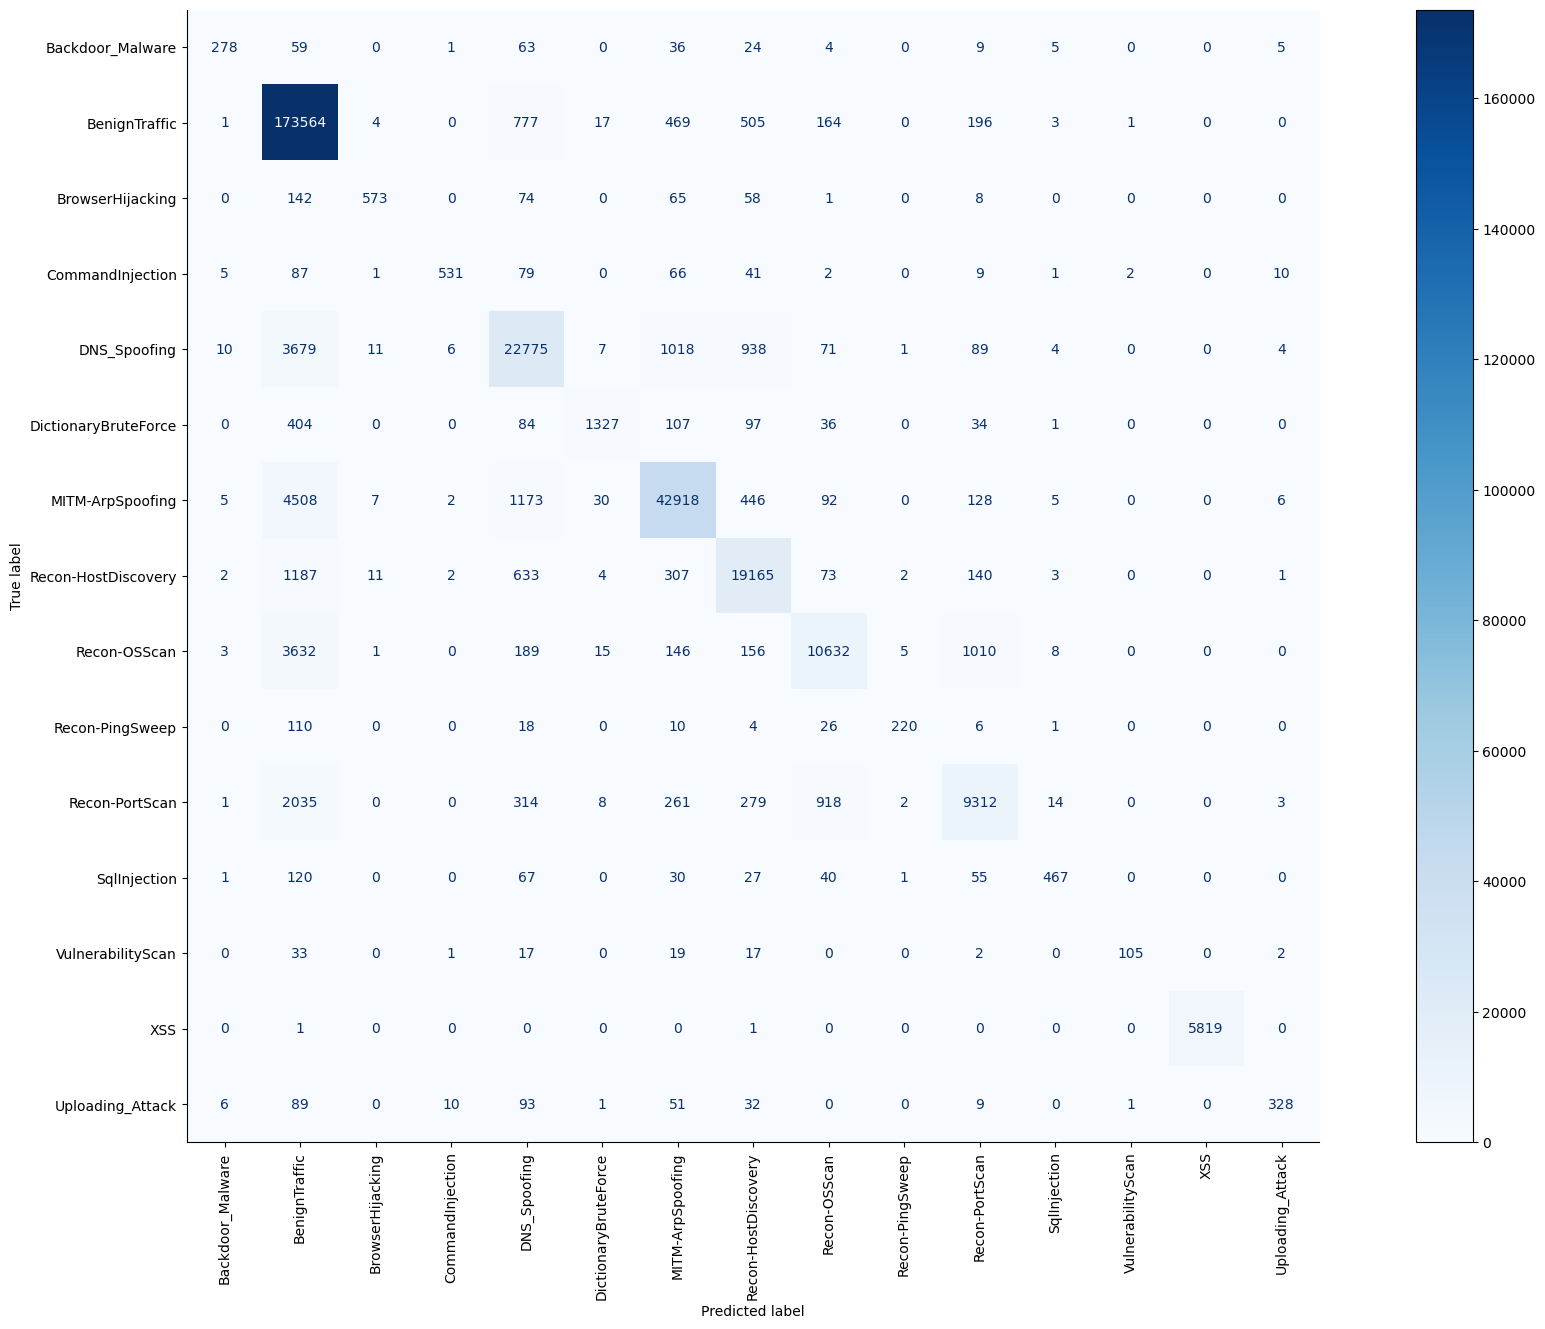

In [ ]:
%%time

second_stage_model = RandomForestClassifier(
    criterion='entropy',
    class_weight='balanced',
    bootstrap=False,
    max_depth=45,
    max_features=17,
    n_estimators=80,
    n_jobs=n_jobs,
    random_state=seed
)

X_train, X_test, y_train, y_test = second_stage_df_split

model_utils.train_model(second_stage_model, X_train, y_train)
model_utils.evaluate_model(second_stage_model, X_test, y_test)

In [21]:
# for node in second_stage_model.estimators_:
#     print(f"Depth: {node.tree_.max_depth:2d}, Nodes: {node.tree_.node_count:6_d}, Leaves: {node.tree_.n_leaves:6_d}")

### 7 + 1 Attacks

In [22]:
%%time

simplified_second_layer_target = (
    df_second_stage.general_label
    .where(df_second_stage.general_label.isin(simplified_second_layer_labels), 'Benign')
    .astype('category')
    .cat.remove_unused_categories()
)

simplified_second_stage_df_split = model_utils.get_train_test_split(
    df_second_stage,
    target=simplified_second_layer_target,
    train_frac=0.80
)

Training dataset size: 1.3M (80.0%).
Test dataset size: 316.3k (20.0%).
CPU times: user 1.44 s, sys: 127 ms, total: 1.57 s
Wall time: 1.57 s


Execution time (Model fit): 0:02:54.743301
Execution time (Predict): 0:00:00.941022
              precision    recall  f1-score   support

      Benign     0.9340    0.9801    0.9565    175701
  BruteForce     0.9446    0.6364    0.7604      2090
       Recon     0.9160    0.8700    0.8924     56690
    Spoofing     0.9332    0.8875    0.9098     77933
         Web     0.9351    0.6151    0.7420      3863

    accuracy                         0.9308    316277
   macro avg     0.9326    0.7978    0.8522    316277
weighted avg     0.9308    0.9308    0.9308    316277

CPU times: user 1h 25min 43s, sys: 4.88 s, total: 1h 25min 48s
Wall time: 2min 57s


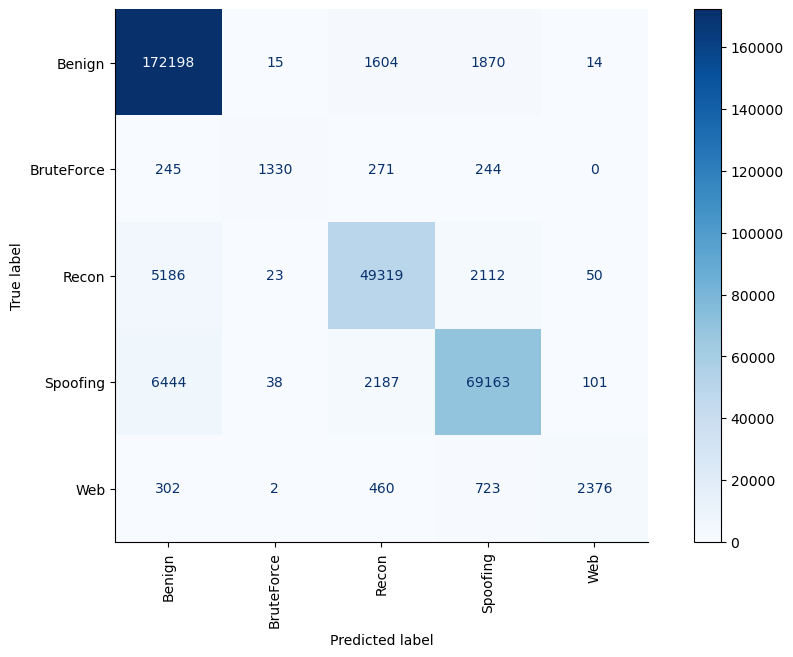

In [23]:
%%time

simplified_second_stage_model = RandomForestClassifier(
    criterion='entropy',
    class_weight='balanced',
    bootstrap=False,
    max_depth=45,
    max_features=17,
    n_estimators=80,
    n_jobs=n_jobs,
    random_state=seed
)

X_train, X_test, y_train, y_test = simplified_second_stage_df_split

model_utils.train_model(simplified_second_stage_model, X_train, y_train)
model_utils.evaluate_model(simplified_second_stage_model, X_test, y_test)

# Open questions from the EDA

## Simple baseline

In [ ]:
%%time

test_df_split = model_utils.get_train_test_split(
    df,
    target='general_label',
    sample_size=5_000_000,
    train_frac=0.80
)

Training dataset size: 4.0M (80.0%).
Test dataset size: 1.0M (20.0%).
CPU times: user 15 s, sys: 4.28 s, total: 19.3 s
Wall time: 19.3 s


Execution time (Model fit): 0:01:26.064270
Execution time (Predict): 0:00:02.862032
              precision    recall  f1-score   support

      Benign     0.9153    0.9753    0.9444     23650
  BruteForce     0.9930    0.4846    0.6514       293
        DDoS     0.9998    1.0000    0.9999    726946
         DoS     0.9998    0.9997    0.9998    174022
       Mirai     0.9999    0.9999    0.9999     56700
       Recon     0.8906    0.8114    0.8491      7485
    Spoofing     0.8948    0.8574    0.8757     10349
         Web     0.9774    0.3117    0.4727       555

    accuracy                         0.9959   1000000
   macro avg     0.9588    0.8050    0.8491   1000000
weighted avg     0.9959    0.9959    0.9959   1000000

CPU times: user 37min 22s, sys: 18.3 s, total: 37min 41s
Wall time: 1min 34s


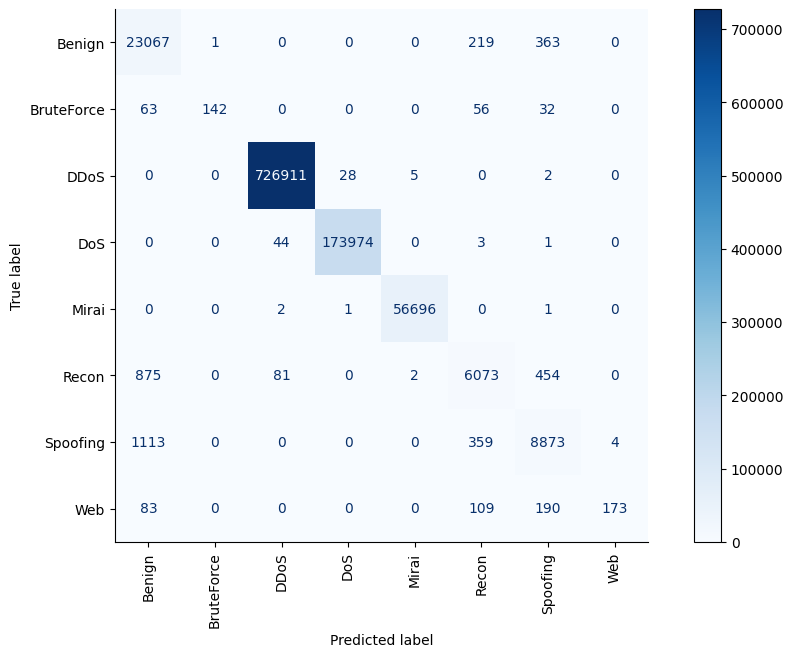

In [ ]:
%%time

test_model = RandomForestClassifier(
    n_jobs=n_jobs,
    random_state=seed
)

X_train, X_test, y_train, y_test = test_df_split

model_utils.train_model(test_model, X_train, y_train)
model_utils.evaluate_model(test_model, X_test, y_test)

### Model without duplicates

In [ ]:
%%time

test_df_split = model_utils.get_train_test_split(
    df.drop_duplicates(),
    target='general_label',
    sample_size=5_000_000,
    train_frac=0.80
)

Training dataset size: 4.0M (80.0%).
Test dataset size: 1.0M (20.0%).
CPU times: user 4min 36s, sys: 31.4 s, total: 5min 7s
Wall time: 5min 7s


Execution time (Model fit): 0:01:49.125567
Execution time (Predict): 0:00:02.886750
              precision    recall  f1-score   support

      Benign     0.9152    0.9774    0.9453     39064
  BruteForce     1.0000    0.4793    0.6480       434
        DDoS     0.9997    0.9999    0.9998    625356
         DoS     0.9998    0.9997    0.9997    229134
       Mirai     0.9999    0.9999    0.9999     75332
       Recon     0.8966    0.8218    0.8576     12443
    Spoofing     0.9070    0.8596    0.8827     17351
         Web     0.9735    0.3318    0.4949       886

    accuracy                         0.9935   1000000
   macro avg     0.9615    0.8087    0.8535   1000000
weighted avg     0.9935    0.9935    0.9935   1000000

CPU times: user 48min 4s, sys: 12.5 s, total: 48min 16s
Wall time: 1min 57s


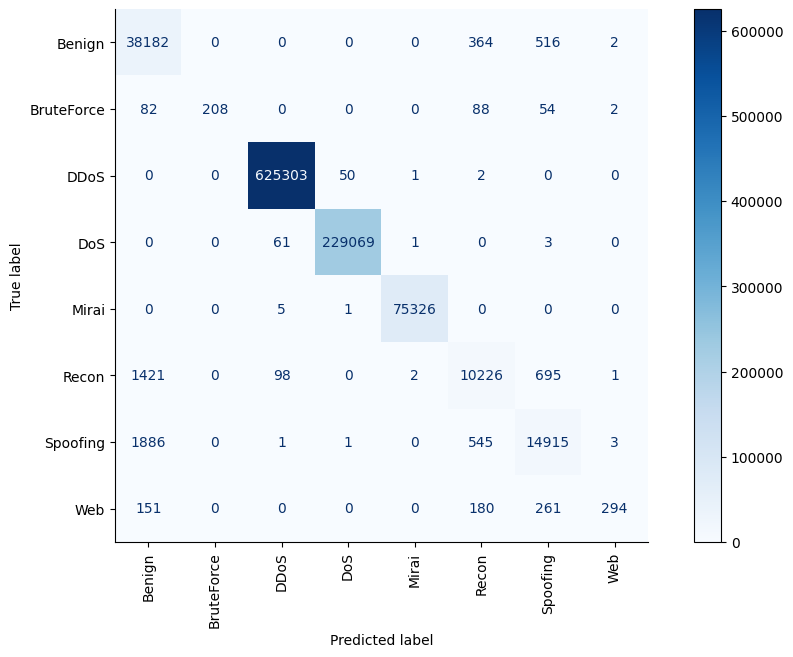

In [ ]:
%%time

test_model = RandomForestClassifier(
    n_jobs=n_jobs,
    random_state=seed
)

X_train, X_test, y_train, y_test = test_df_split

model_utils.train_model(test_model, X_train, y_train)
model_utils.evaluate_model(test_model, X_test, y_test)

### Model without IAT

In [ ]:
%%time

test_df_split = model_utils.get_train_test_split(
    df.drop(columns=['IAT']),
    target='general_label',
    sample_size=5_000_000,
    train_frac=0.80
)

Training dataset size: 4.0M (80.0%).
Test dataset size: 1.0M (20.0%).
CPU times: user 18.9 s, sys: 6.47 s, total: 25.3 s
Wall time: 25.3 s


Execution time (Model fit): 0:02:22.128800
Execution time (Predict): 0:00:05.881777
              precision    recall  f1-score   support

      Benign     0.8426    0.9542    0.8949     23710
  BruteForce     0.9286    0.1403    0.2437       278
        DDoS     0.9387    0.9582    0.9484    728000
         DoS     0.8079    0.7379    0.7713    172993
       Mirai     0.9993    0.9959    0.9976     56534
       Recon     0.7734    0.6749    0.7208      7453
    Spoofing     0.8288    0.7125    0.7663     10509
         Web     0.9767    0.0803    0.1484       523

    accuracy                         0.9168   1000000
   macro avg     0.8870    0.6568    0.6864   1000000
weighted avg     0.9168    0.9168    0.9168   1000000

CPU times: user 1h 3min 27s, sys: 18.5 s, total: 1h 3min 46s
Wall time: 2min 34s


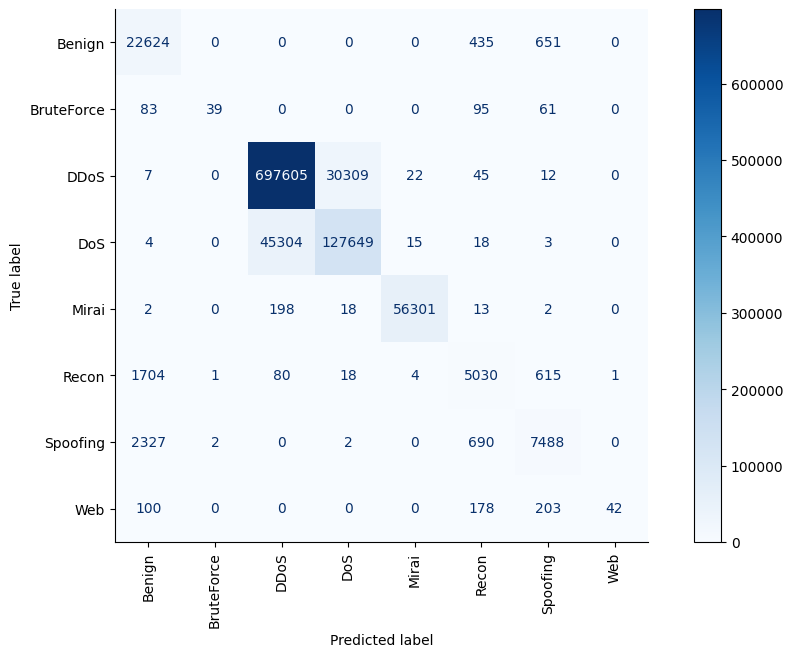

In [ ]:
%%time

test_model = RandomForestClassifier(
    n_jobs=n_jobs,
    random_state=seed
)

X_train, X_test, y_train, y_test = test_df_split

model_utils.train_model(test_model, X_train, y_train)
model_utils.evaluate_model(test_model, X_test, y_test)